## Generating Buy/Sell Signals Using Market Data and ZScores

### Squeezemetrics data:

DIX is a measure of dark pool buying in the stock market. Dark pools are private exchanges for
trading securities that are not accessible by the investing public. Dark pools were created in order
to facilitate block trading by institutional investors who did not wish to impact the markets with
their large orders. While their orders don’t initially affect the market, as they are done off
exchange, the DIX is a good measure of institutional buying/selling, and in general, if large
institutions are buying, stock prices go up, whereas if they are selling, prices go down.

The GEX is a measure of market maker gamma exposure. Gamma is a measure of the ratio of open interest in calls/puts, and market maker exposure to these options.  This is an important concept, because market makers who sell these options must remain delta neutral, meaning, if they sell a call, they must buy 100 shares of the underlying security, and if they sell a put, they must also sell 100 shares of the underlying security.  When the GEX is negative, generally, price movements up cause more buying, and price movements down cause more selling, and thus, increased volatility. The inverse is also true; higher gamma exposure leads to lower volatility.

https://squeezemetrics.com/monitor/dix

In [16]:
import pandas as pd
import numpy as np

DIX = pd.read_csv("/Users/pdziki/Downloads/DIX.csv")
DIX = DIX.drop(columns=["price"])
DIX = DIX.rename(columns={"date": "Date"})
DIX['Date']= pd.to_datetime(DIX['Date'])

Using the yfinance API to pull market data from yahoo finance

In [17]:
import yfinance as yf
from datetime import date
import datetime

today = date.today()
spy= yf.Ticker("spy")
spy_historical = spy.history(start="2011-05-02", end=today)
spy_historical.reset_index(inplace = True, drop = False)

In [18]:
joinedDf = pd.merge(spy_historical, DIX, how='inner', on="Date",
         left_index=False, right_index=False, sort=False,
         copy=True, indicator=False,
         validate=None)
joinedDf = joinedDf.drop(columns=['Open', 'High', "Low", "Dividends", "Stock Splits"])

In [19]:
joinedDf['50 Day SMA'] = joinedDf['Close'].rolling(50).mean()
joinedDf['200 Day SMA'] = joinedDf['Close'].rolling(200).mean()
joinedDf['50 Day EWMA'] = joinedDf['Close'].ewm(span=50).mean()
joinedDf['200 Day EWMA'] = joinedDf['Close'].ewm(span=200).mean()

Creating a function to calculate the RSI over the last 14 trading days

In [20]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()    

    up_chg = 0 * diff
    down_chg = 0 * diff
    
    up_chg[diff > 0] = diff[ diff>0 ]
    
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [21]:
joinedDf['RSI'] = computeRSI(joinedDf['Close'], 14)

In [22]:
from scipy.stats import zscore

joinedDf['Distance from 50 Day'] = joinedDf['Close'] - joinedDf['50 Day SMA']
joinedDf['Distance from 200 Day'] = joinedDf['Close'] - joinedDf['200 Day SMA']
joinedDf["Daily Return"] = np.nan
joinedDf['3 Day Return'] = np.nan
joinedDf['5 Day Return'] = np.nan
joinedDf['15 Day Return'] = np.nan
joinedDf['30 Day Return'] = np.nan
joinedDf['60 Day Return'] = np.nan

In [23]:
def calculate_returns(time, column_name, dataframe):
    
    for ind in dataframe.index:
        if ind >= len(dataframe) - time:
            dataframe[column_name][ind] = 0
        else:
            dataframe[column_name][ind] = ((dataframe['Close'][ind+time] - dataframe['Close'][ind]) /(dataframe['Close'][ind])) * 100


In [24]:
calculate_returns(1, "Daily Return", joinedDf)
calculate_returns(3, "3 Day Return", joinedDf)
calculate_returns(5, "5 Day Return", joinedDf)
calculate_returns(15, "15 Day Return", joinedDf)
calculate_returns(30, "30 Day Return", joinedDf)
calculate_returns(60, "60 Day Return", joinedDf)

<ipython-input-23-cd7861beb4c9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column_name][ind] = ((dataframe['Close'][ind+time] - dataframe['Close'][ind]) /(dataframe['Close'][ind])) * 100
<ipython-input-23-cd7861beb4c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column_name][ind] = 0


In [25]:
joinedDf

,Date,Close,Volume,dix,gex,50 Day SMA,200 Day SMA,50 Day EWMA,200 Day EWMA,RSI,Distance from 50 Day,Distance from 200 Day,Daily Return,3 Day Return,5 Day Return,15 Day Return,30 Day Return,60 Day Return
0,2011-05-02,110.301651,126278700,0.378842,1.897313e+09,NaN,NaN,110.301651,110.301651,NaN,NaN,NaN,-0.359731,-1.916008,-1.101183,-3.053905,-5.065316,-3.650365
1,2011-05-03,109.904861,138375000,0.383411,1.859731e+09,NaN,NaN,110.099288,110.102264,NaN,NaN,NaN,-0.663082,-1.127185,0.103128,-2.784911,-6.417134,-3.583838
2,2011-05-04,109.176102,182678500,0.392122,1.717764e+09,NaN,NaN,109.779170,109.790451,NaN,NaN,NaN,-0.904812,-0.081587,-0.289233,-1.809694,-5.584793,-3.603658
3,2011-05-05,108.188263,226900000,0.405457,1.361864e+09,NaN,NaN,109.357268,109.383876,NaN,NaN,NaN,0.441608,1.691441,1.100226,-0.456565,-4.438363,-3.137136
4,2011-05-06,108.666031,222787200,0.418649,1.490329e+09,NaN,NaN,109.207744,109.237421,NaN,NaN,NaN,0.387423,0.178803,-0.119265,-0.514222,-4.371802,-6.026754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,2022-05-11,392.750000,142361000,0.454010,-2.519691e+09,433.263184,444.967103,430.477634,434.639798,32.011627,-40.513184,-52.217103,-0.104393,1.868872,0.000000,0.000000,0.000000,0.000000
2777,2022-05-12,392.339996,125090800,0.418991,-3.429697e+09,432.379307,444.756067,428.982040,434.218904,31.856264,-40.039310,-52.416071,2.390785,4.073001,0.000000,0.000000,0.000000,0.000000
2778,2022-05-13,401.720001,104029300,0.452952,-1.426613e+09,431.726495,444.582920,427.912941,433.895532,39.134247,-30.006494,-42.862919,-0.405756,0.000000,0.000000,0.000000,0.000000,0.000000
2779,2022-05-16,400.089996,78622400,0.520182,-1.135155e+09,431.111663,444.412218,426.821845,433.559159,38.367384,-31.021667,-44.322222,2.057040,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
joinedDf.describe() 

,Close,Volume,dix,gex,50 Day SMA,200 Day SMA,50 Day EWMA,200 Day EWMA,RSI,Distance from 50 Day,Distance from 200 Day,Daily Return,3 Day Return,5 Day Return,15 Day Return,30 Day Return,60 Day Return
count,2781.000000,2.781000e+03,2781.000000,2.781000e+03,2732.000000,2582.000000,2781.000000,2781.000000,2767.000000,2732.000000,2582.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000
mean,228.084749,1.106309e+08,0.423119,2.733046e+09,227.405959,224.685080,225.280290,216.373296,56.164767,2.853071,13.059489,0.053008,0.156209,0.258345,0.785923,1.612551,3.248037
std,98.060697,6.507524e+07,0.029536,2.826090e+09,96.217387,88.217792,96.518099,90.317412,11.303630,9.410408,16.034274,1.086834,1.768761,2.230589,3.686462,4.834337,6.317916
min,89.917915,2.027000e+07,0.330555,-7.496823e+09,95.737191,102.792454,96.880419,100.350482,16.683245,-81.758140,-74.843867,-10.942367,-12.578359,-17.969316,-27.444745,-32.492175,-30.186775
25%,157.726440,6.742900e+07,0.403039,1.219949e+09,157.653324,162.509272,154.593111,145.718310,48.485603,-0.186609,6.324516,-0.353625,-0.596966,-0.649250,-0.712305,-0.391457,0.150492
50%,197.330612,9.361800e+07,0.422078,2.249543e+09,196.578432,201.052110,194.777714,189.550129,57.561235,3.630893,11.552474,0.066905,0.264689,0.418426,1.189459,2.074632,3.976078
75%,277.285736,1.345513e+08,0.441187,3.492813e+09,275.843151,273.804162,274.684555,269.871212,64.556922,6.644425,16.321848,0.551904,1.046504,1.412198,2.732925,4.384016,7.007643
max,476.230530,7.178287e+08,0.546802,2.421867e+10,464.546038,446.093250,462.788467,437.721084,87.192036,36.736083,59.002874,9.060325,17.156324,17.358136,27.288627,28.365107,39.789195


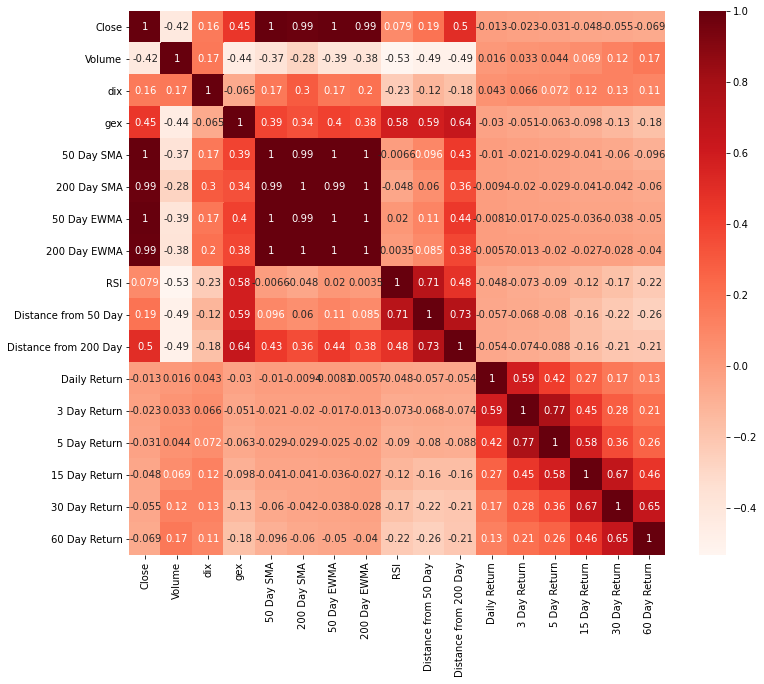

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(12,10))
cor = joinedDf.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

The above heatmap shows that in general, each of these data points have a relatively low/no correlation with price, and future return on investment.  However, we will see that each of these metrics can be incredibly helpful in generating buy/sell signals when they are at extreme levels.  

In [28]:
joinedDf['Distance from 50 Day zscore'] = zscore(joinedDf['Distance from 50 Day'], nan_policy='omit')
joinedDf['Distance from 200 Day zscore'] = zscore(joinedDf['Distance from 200 Day'], nan_policy='omit')
joinedDf['RSI zscore'] = zscore(joinedDf['RSI'], nan_policy='omit')
joinedDf['gex zscore'] = zscore(joinedDf['gex'], nan_policy='omit')
joinedDf['dix zscore'] = zscore(joinedDf['dix'], nan_policy='omit')
joinedDf['volume zscore'] = zscore(joinedDf['Volume'], nan_policy='omit')
pd.set_option('display.max_columns', None)
joinedDf

,Date,Close,Volume,dix,gex,50 Day SMA,200 Day SMA,50 Day EWMA,200 Day EWMA,RSI,Distance from 50 Day,Distance from 200 Day,Daily Return,3 Day Return,5 Day Return,15 Day Return,30 Day Return,60 Day Return,Distance from 50 Day zscore,Distance from 200 Day zscore,RSI zscore,gex zscore,dix zscore,volume zscore
0,2011-05-02,110.301651,126278700,0.378842,1.897313e+09,NaN,NaN,110.301651,110.301651,NaN,NaN,NaN,-0.359731,-1.916008,-1.101183,-3.053905,-5.065316,-3.650365,NaN,NaN,NaN,-0.295774,-1.499353,0.240500
1,2011-05-03,109.904861,138375000,0.383411,1.859731e+09,NaN,NaN,110.099288,110.102264,NaN,NaN,NaN,-0.663082,-1.127185,0.103128,-2.784911,-6.417134,-3.583838,NaN,NaN,NaN,-0.309074,-1.344634,0.426415
2,2011-05-04,109.176102,182678500,0.392122,1.717764e+09,NaN,NaN,109.779170,109.790451,NaN,NaN,NaN,-0.904812,-0.081587,-0.289233,-1.809694,-5.584793,-3.603658,NaN,NaN,NaN,-0.359318,-1.049663,1.107342
3,2011-05-05,108.188263,226900000,0.405457,1.361864e+09,NaN,NaN,109.357268,109.383876,NaN,NaN,NaN,0.441608,1.691441,1.100226,-0.456565,-4.438363,-3.137136,NaN,NaN,NaN,-0.485274,-0.598093,1.787008
4,2011-05-06,108.666031,222787200,0.418649,1.490329e+09,NaN,NaN,109.207744,109.237421,NaN,NaN,NaN,0.387423,0.178803,-0.119265,-0.514222,-4.371802,-6.026754,NaN,NaN,NaN,-0.439809,-0.151385,1.723796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,2022-05-11,392.750000,142361000,0.454010,-2.519691e+09,433.263184,444.967103,430.477634,434.639798,32.011627,-40.513184,-52.217103,-0.104393,1.868872,0.000000,0.000000,0.000000,0.000000,-4.609172,-4.071855,-2.137146,-1.858993,1.046041,0.487679
2777,2022-05-12,392.339996,125090800,0.418991,-3.429697e+09,432.379307,444.756067,428.982040,434.218904,31.856264,-40.039310,-52.416071,2.390785,4.073001,0.000000,0.000000,0.000000,0.000000,-4.558807,-4.084266,-2.150893,-2.181053,-0.139782,0.222243
2778,2022-05-13,401.720001,104029300,0.452952,-1.426613e+09,431.726495,444.582920,427.912941,433.895532,39.134247,-30.006494,-42.862919,-0.405756,0.000000,0.000000,0.000000,0.000000,0.000000,-3.492471,-3.488355,-1.506914,-1.472142,1.010213,-0.101464
2779,2022-05-16,400.089996,78622400,0.520182,-1.135155e+09,431.111663,444.412218,426.821845,433.559159,38.367384,-31.021667,-44.322222,2.057040,0.000000,0.000000,0.000000,0.000000,0.000000,-3.600369,-3.579384,-1.574769,-1.368993,3.286817,-0.491958


In order to determine what constitutes "extreme levels", we can use zScores.  zScores allow us to identify outliers within each data field, and these outliers are far more helpful in predicting future price action.

In [29]:
dix_returns = joinedDf[['Date','dix', 'dix zscore', 'Daily Return', '5 Day Return', '15 Day Return', '30 Day Return', '60 Day Return']].copy()
dix_returns = dix_returns.sort_values(by=['dix'])
dix_two_sigma = dix_returns[dix_returns['dix zscore'] >= 2] 
dix_two_sigma

,Date,dix,dix zscore,Daily Return,5 Day Return,15 Day Return,30 Day Return,60 Day Return
75,2011-08-17,0.482254,2.002484,-4.311871,-1.328698,-0.526468,-2.523307,4.423114
1930,2019-01-02,0.482259,2.002638,-2.386280,3.113762,5.344136,9.673017,13.408039
2241,2020-03-27,0.482826,2.021839,3.247565,-2.063756,11.115940,15.421044,23.677371
134,2011-11-09,0.482996,2.027619,0.941873,0.747017,1.469632,2.358332,10.137100
2265,2020-05-01,0.483067,2.030015,0.275846,3.412438,4.473299,8.578813,14.071715
...,...,...,...,...,...,...,...,...
2284,2020-05-29,0.522603,3.368823,0.404167,4.935590,1.865865,3.912145,13.179893
2725,2022-02-28,0.522827,3.376402,-1.523026,-3.939268,2.093432,1.066501,0.000000
2299,2020-06-19,0.525397,3.463440,0.641498,-2.783183,2.008799,6.528634,10.215785
2714,2022-02-10,0.541069,3.994140,-1.971873,-2.728571,-3.816880,1.063013,-11.108571


In [30]:
rsi_returns = joinedDf[['Date','RSI', 'RSI zscore', 'Daily Return', '5 Day Return', '15 Day Return', '30 Day Return', '60 Day Return']].copy()
rsi_returns = rsi_returns.sort_values(by=['RSI'])
rsi_returns.dropna()
rsi_two_sigma = rsi_returns[rsi_returns['RSI zscore'] > 2] 
rsi_two_sigma.describe()


,RSI,RSI zscore,Daily Return,5 Day Return,15 Day Return,30 Day Return,60 Day Return
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,81.470276,2.239111,-0.065264,-0.090007,-2.157008,-0.892991,-2.942120
std,2.048892,0.181292,0.856080,2.055970,4.025330,2.208890,7.304581
min,78.820780,2.004675,-3.441429,-6.656415,-9.199072,-4.259479,-24.264636
25%,79.784408,2.089940,-0.323857,-0.518060,-5.835919,-2.725019,-4.772458
50%,81.140894,2.209966,-0.031787,0.247319,-1.055677,-1.092623,-3.239438
75%,82.304305,2.312909,0.204915,1.430193,0.786636,0.009234,1.526933
max,87.192036,2.745391,1.446397,2.200312,4.118211,3.840681,9.123282


In [31]:
fiftydistance_returns = joinedDf[['Date','Distance from 50 Day', 'Distance from 50 Day zscore', 'Daily Return', '5 Day Return', '15 Day Return', '30 Day Return', '60 Day Return']].copy()
fiftydistance_returns = fiftydistance_returns.sort_values(by=['Distance from 50 Day'])
fiftydistance_returns.dropna()
fifty_two_sigma = fiftydistance_returns[fiftydistance_returns['Distance from 50 Day zscore'] > 2.0] 
fifty_two_sigma.describe()

,Distance from 50 Day,Distance from 50 Day zscore,Daily Return,5 Day Return,15 Day Return,30 Day Return,60 Day Return
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,26.171068,2.478348,-0.058980,-0.093525,-0.958303,1.860403,8.289042
std,3.923102,0.416966,1.573083,3.355583,4.249205,4.302607,5.720746
min,22.137335,2.049624,-5.764892,-6.656415,-9.199072,-14.906292,-4.427305
25%,22.886941,2.129295,-0.542881,-2.335914,-3.910350,0.470420,3.328398
50%,25.187851,2.373847,0.137644,-0.294405,-0.846147,2.173486,9.721483
75%,27.989475,2.671617,0.856470,2.865982,2.098787,4.858614,13.134026
max,36.736083,3.601248,2.562963,5.776466,8.742394,7.991461,15.126673


In [32]:
twohundreddistance_returns = joinedDf[['Date','Distance from 200 Day', 'Distance from 200 Day zscore', 'Daily Return', '5 Day Return', '15 Day Return', '30 Day Return', '60 Day Return']].copy()
twohundreddistance_returns = twohundreddistance_returns.sort_values(by=['Distance from 200 Day'])
twohundreddistance_returns.dropna()
twohundred_two_sigma = twohundreddistance_returns[twohundreddistance_returns['Distance from 200 Day zscore'] > 2] 
twohundred_two_sigma.describe()

,Distance from 200 Day,Distance from 200 Day zscore,Daily Return,5 Day Return,15 Day Return,30 Day Return,60 Day Return
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,50.113524,2.311374,-0.004943,0.117701,0.907253,2.243956,5.248211
std,3.219075,0.200801,0.714476,1.344309,2.017864,2.305752,3.014591
min,45.147901,2.001627,-3.441429,-6.656415,-9.199072,-3.807981,-5.811578
25%,47.542594,2.151004,-0.341536,-0.561067,0.121188,0.864119,4.022102
50%,49.524878,2.274656,0.052495,0.251911,1.276430,2.329102,5.744922
75%,52.559042,2.463922,0.354299,1.094070,2.191930,4.019725,7.226942
max,59.002874,2.865879,1.485751,2.715857,4.856296,6.399318,10.949273


In [33]:
gex_returns = joinedDf[['Date','gex', 'gex zscore', 'Daily Return', '5 Day Return', '15 Day Return', '30 Day Return', '60 Day Return']].copy()
gex_returns = gex_returns.sort_values(by=['gex'])
gex_two_sigma = gex_returns[gex_returns['gex zscore'] > 2] 
gex_two_sigma.describe()

,gex,gex zscore,Daily Return,5 Day Return,15 Day Return,30 Day Return,60 Day Return
count,1.160000e+02,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,1.244555e+10,3.437346,-0.045780,0.024641,0.321510,1.042015,1.123908
std,3.781935e+09,1.338462,0.866060,1.481462,2.614194,3.461388,7.891012
min,8.424335e+09,2.014201,-5.764892,-6.656415,-9.199072,-14.906292,-24.842645
25%,9.661257e+09,2.451959,-0.343644,-0.682112,-1.366022,-0.067798,-1.382878
50%,1.146234e+10,3.089380,0.035355,0.078406,0.814162,1.743519,3.770574
75%,1.407604e+10,4.014394,0.366837,1.114141,2.247723,3.074711,6.199689
max,2.421867e+10,7.603964,1.608766,2.970916,5.516391,7.602259,9.489984
